In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

import pickle

In [26]:
df = pd.read_csv('anime_population.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,created_at,description,title_en,title_en_jp,average_rating,community,favourite_count,popularity_rank,age_rating,status,...,age_rating_guide_Violence & profanity,age_rating_guide_Violence & profanity),"age_rating_guide_Violence, Profanity",age_rating_guide_violence & profanity,show_type_ONA,show_type_OVA,show_type_TV,show_type_movie,show_type_music,show_type_special
0,2013-02-20T16:00:13.609Z,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,82.47,117545,4509,30,R,finished,...,0,0,0,0,0,0,1,0,0,0
1,2013-02-20T16:00:16.085Z,"Another day, another bounty—such is the life o...",Cowboy Bebop: The Movie,Cowboy Bebop: Tengoku no Tobira,82.27,31334,306,289,R,finished,...,0,0,0,0,0,0,0,1,0,0
2,2013-02-20T16:00:17.112Z,"Vash the Stampede is the man with a $$60,000,0...",Trigun,Trigun,82.25,45553,1230,170,PG,finished,...,0,0,0,0,0,0,1,0,0,0
3,2013-02-20T16:00:18.116Z,Witches are individuals with special powers li...,Witch Hunter Robin,Witch Hunter Robin,72.31,7125,46,1524,PG,finished,...,0,0,0,0,0,0,1,0,0,0
4,2013-02-20T16:00:18.955Z,It is the dark century and the people are suff...,Beet the Vandel Buster,Beet the Vandel Buster,69.08,957,4,4757,PG,finished,...,0,0,0,0,0,0,1,0,0,0


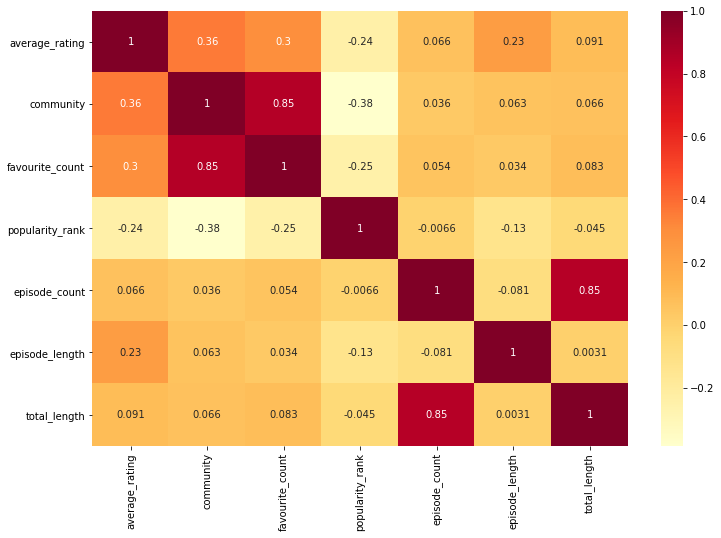

In [27]:
num_feat = ['average_rating', 'community', 'favourite_count', 'popularity_rank', 'episode_count','episode_length', 'total_length']
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_feat].corr(), annot=True, cmap='YlOrRd')

In [28]:
df[num_feat].isnull().sum()

average_rating     0
community          0
favourite_count    0
popularity_rank    0
episode_count      0
episode_length     0
total_length       0
dtype: int64

In [29]:
df['episode_count'].describe()

count    11186.000000
mean        13.741105
std         53.124861
min          1.000000
25%          1.000000
50%          2.000000
75%         13.000000
max       3057.000000
Name: episode_count, dtype: float64

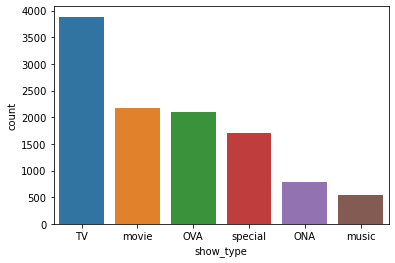

In [30]:
sns.countplot(df['show_type'])

In [31]:
pd.crosstab(df['status'], df['show_type'])

show_type,ONA,OVA,TV,movie,music,special
status,,,,,,
current,11,3,30,1,0,4
finished,770,2093,3847,2167,549,1694
tba,1,4,9,2,0,0
upcoming,0,0,0,1,0,0


In [32]:
for cat in df['show_type'].unique():
    mask = df['episode_count'].isna()
    ind = df.loc[mask][df['show_type'] == cat].index
    df.loc[ind, 'episode_count'] = np.round(df[df['show_type'] == cat]['episode_count'].mean())
df['episode_count'].isna().sum()

<ipython-input-32-f69374b5fc7b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ind = df.loc[mask][df['show_type'] == cat].index


0

In [33]:
for cat in df['show_type'].unique():
    mask = df['episode_length'].isna()
    ind = df.loc[mask][df['show_type'] == cat].index
    df.loc[ind, 'episode_length'] = np.round(df[df['show_type'] == cat]['episode_length'].mean())
df['episode_length'].isna().sum()

<ipython-input-33-821996e5a36f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ind = df.loc[mask][df['show_type'] == cat].index


0

In [34]:
df['total_length'] = df['episode_count'] * df['episode_length']

In [40]:
final_df = df[[col for col in df.columns if df[col].dtype != 'O']]
# final_df.drop(['index'], axis=1, inplace=True)
final_df.columns

Index(['average_rating', 'community', 'favourite_count', 'popularity_rank',
       'episode_count', 'episode_length', 'total_length', 'age_rating_G',
       'age_rating_PG', 'age_rating_R', 'status_current', 'status_finished',
       'status_tba', 'status_upcoming',
       'age_rating_guide_13 - Teens 13 or older',
       'age_rating_guide_17+ (Violence and Profanity)',
       'age_rating_guide_17+ (violence & profanity)',
       'age_rating_guide_17+ Violence, Profanity', 'age_rating_guide_All Ages',
       'age_rating_guide_Children', 'age_rating_guide_Children 7 or older',
       'age_rating_guide_For children age 7 and above',
       'age_rating_guide_Mild Nudity', 'age_rating_guide_Mild Violence',
       'age_rating_guide_None', 'age_rating_guide_PG-13',
       'age_rating_guide_Sexual language and Imagery',
       'age_rating_guide_Teens 13 and older',
       'age_rating_guide_Teens 13 or Older',
       'age_rating_guide_Teens 13 or older', 'age_rating_guide_Violence',
       'ag

In [12]:
final_df = pd.get_dummies(final_df)

In [41]:
neigh = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

In [42]:
neigh.fit(final_df.values)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [43]:
df[df['title_en'] == 'Death Note']

,created_at,description,title_en,title_en_jp,average_rating,community,favourite_count,popularity_rank,age_rating,status,...,age_rating_guide_Violence & profanity,age_rating_guide_Violence & profanity),"age_rating_guide_Violence, Profanity",age_rating_guide_violence & profanity,show_type_ONA,show_type_OVA,show_type_TV,show_type_movie,show_type_music,show_type_special
1314,2013-02-20T16:22:02.337Z,"A shinigami, as a god of death, can kill any p...",Death Note,Death Note,83.28,283968,5573,6,R,finished,...,0,0,1,0,0,0,1,0,0,0


In [44]:
test = final_df[final_df['average_rating']==83.28].values
test

array([[8.32800e+01, 2.83968e+05, 5.57300e+03, 6.00000e+00, 3.70000e+01,
        2.30000e+01, 8.51000e+02, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00]])

In [45]:
ind = neigh.kneighbors(test, return_distance=False)
ind

array([[ 1314,  6619,  8238,  6279,  9063,  9192,  6037,  5664,  6425,
         6478,  6618,  6977,  2380,  9256,  5047,   192,  6772, 10001,
          141,  5526]], dtype=int64)

In [46]:
df.iloc[ind[0]]['title_en']

1314                                            Death Note
6619                                              Noragami
8238                                          Death Parade
6279                                       Attack on Titan
9063     KonoSuba: God's Blessing on This Wonderful World!
9192                                                ERASED
6037                     Love, Chunibyo & Other Delusions!
5664                                         Wolf Children
6425                                    Fate/Zero Season 2
6478                                   Beyond the Boundary
6618                                      No Game, No Life
6977                                     Your Lie in April
2380               Code Geass: Lelouch of the Rebellion R2
9256              Re:ZERO -Starting Life in Another World-
5047                   anohana: The Flower We Saw That Day
192                                             Elfen Lied
6772                                              Haikyu

In [51]:
file = open('model.pkl', 'wb')
pickle.dump(neigh, file)

In [48]:
df[df['title_en']=='Death Note'].index.values[0]

1314

In [49]:
test.shape

(1, 41)

In [50]:
final_df.head().columns

Index(['average_rating', 'community', 'favourite_count', 'popularity_rank',
       'episode_count', 'episode_length', 'total_length', 'age_rating_G',
       'age_rating_PG', 'age_rating_R', 'status_current', 'status_finished',
       'status_tba', 'status_upcoming',
       'age_rating_guide_13 - Teens 13 or older',
       'age_rating_guide_17+ (Violence and Profanity)',
       'age_rating_guide_17+ (violence & profanity)',
       'age_rating_guide_17+ Violence, Profanity', 'age_rating_guide_All Ages',
       'age_rating_guide_Children', 'age_rating_guide_Children 7 or older',
       'age_rating_guide_For children age 7 and above',
       'age_rating_guide_Mild Nudity', 'age_rating_guide_Mild Violence',
       'age_rating_guide_None', 'age_rating_guide_PG-13',
       'age_rating_guide_Sexual language and Imagery',
       'age_rating_guide_Teens 13 and older',
       'age_rating_guide_Teens 13 or Older',
       'age_rating_guide_Teens 13 or older', 'age_rating_guide_Violence',
       'ag

In [52]:
df[df['title_en'] == 'Kengan Ashura Part 2']

,created_at,description,title_en,title_en_jp,average_rating,community,favourite_count,popularity_rank,age_rating,status,...,age_rating_guide_Violence & profanity,age_rating_guide_Violence & profanity),"age_rating_guide_Violence, Profanity",age_rating_guide_violence & profanity,show_type_ONA,show_type_OVA,show_type_TV,show_type_movie,show_type_music,show_type_special
